#Imports

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from sklearn.feature_selection import chi2 , SelectKBest, mutual_info_regression
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

#Exploratory analysis

##Data description:

*   age. Age of primary beneficiary (numeric)
*   sex. Gender of the primary beneficiary (categorical)
*   bmi. Body mass index (numeric)
*   children. Number of children/dependents covered by health insurance (numeric)
*   smoker. smoker (categorical)
*   region. Beneficiary's residential area in the U.S.: northeast,southeast, southwest, northwest (categorical)
*   charges. Health insurance premium (numerical)

##Opening data

In [2]:
link='https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv'
health_raw=pd.read_csv(link)

In [3]:
health_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
health_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


###Checking for duplicates

In [5]:
print(health_raw.duplicated().sum())

1


###Checking categorical variables:

In [6]:
health_raw.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [7]:
cat=['sex', 'smoker','region']
for x in cat:
  print(health_raw[x].value_counts())
  print('\n')

male      676
female    662
Name: sex, dtype: int64


no     1064
yes     274
Name: smoker, dtype: int64


southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64




###Converting categorical variables into dummies/binary variables

In [8]:
health_raw=pd.get_dummies(health_raw, columns=cat)


###Summary statistics:

*   The average age is 39
*   Observations in the sample are overweight and slightly obese given the average bmi of 30.6
*   The number of children covered on average is 1
*   The health insurance premium is on average 13.2K USD
*   Roughly 50% of the sample are female
*   About 20% of the sample are smokers
*   Roughly 24% of the sample lives in the northeast, northwest or southwest regions


In [9]:
health_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801
sex_female,1338.0,0.494768,0.500160,0.0000,0.00000,0.000,1.000000,1.00000
sex_male,1338.0,0.505232,0.500160,0.0000,0.00000,1.000,1.000000,1.00000
smoker_no,1338.0,0.795217,0.403694,0.0000,1.00000,1.000,1.000000,1.00000
smoker_yes,1338.0,0.204783,0.403694,0.0000,0.00000,0.000,0.000000,1.00000
region_northeast,1338.0,0.242152,0.428546,0.0000,0.00000,0.000,0.000000,1.00000
region_northwest,1338.0,0.242900,0.428995,0.0000,0.00000,0.000,0.000000,1.00000


###Graphical analysis

Correlation map:
*   Smoker and charges are relatively highly correlated, as expected, smoking is associated with more health complications which is associated with a more expensive health premium

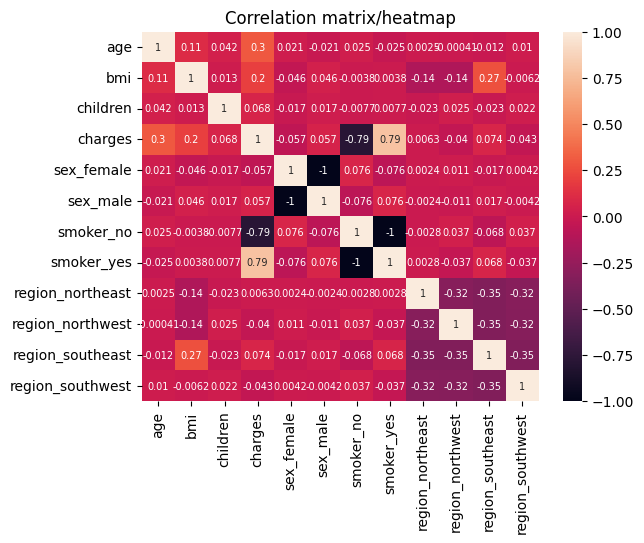

In [10]:
sns.heatmap(health_raw.corr(), annot=True, annot_kws={'size':7})
plt.title('Correlation matrix/heatmap')
plt.show()

Pairplot:
*   There seem to be 3 groups of charges when looking at charges vs age

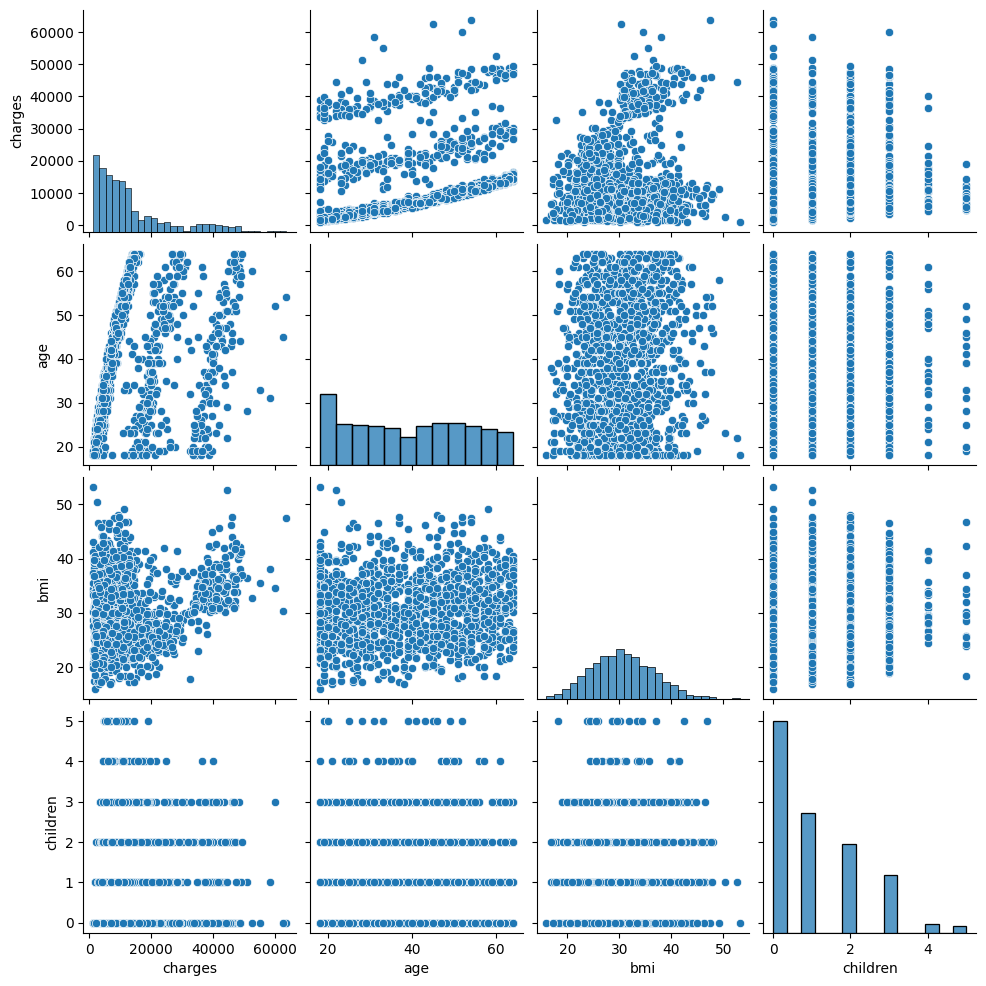

In [11]:
num_vars=['charges','age','bmi','children']
sns.pairplot(health_raw[num_vars], corner=False)
plt.show()

#Preparing data for linear regression

Normalising numerical variables:

In [12]:
cols=['age','bmi','children']
scaler=StandardScaler()
norm = pd.DataFrame(scaler.fit_transform(health_raw[cols]), index=health_raw.index, columns=cols)
health_raw[cols]=norm[cols]
health_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,-1.805565e-16,1.000374,-1.509965,-0.869155,-0.014740,0.839674,1.765289
bmi,1338.0,-2.124194e-16,1.000374,-2.412011,-0.716406,-0.043209,0.661157,3.685522
children,1338.0,-5.576008e-17,1.000374,-0.908614,-0.908614,-0.078767,0.751079,3.240619
charges,1338.0,1.327042e+04,12110.011237,1121.873900,4740.287150,9382.033000,16639.912515,63770.428010
sex_female,1338.0,4.947683e-01,0.500160,0.000000,0.000000,0.000000,1.000000,1.000000
sex_male,1338.0,5.052317e-01,0.500160,0.000000,0.000000,1.000000,1.000000,1.000000
smoker_no,1338.0,7.952167e-01,0.403694,0.000000,1.000000,1.000000,1.000000,1.000000
smoker_yes,1338.0,2.047833e-01,0.403694,0.000000,0.000000,0.000000,0.000000,1.000000
region_northeast,1338.0,2.421525e-01,0.428546,0.000000,0.000000,0.000000,0.000000,1.000000
region_northwest,1338.0,2.428999e-01,0.428995,0.000000,0.000000,0.000000,0.000000,1.000000


Removing duplicated variables to prevent multicollinearity:

In [13]:
health_raw.drop(['sex_male', 'smoker_no', 'region_southwest'], axis=1, inplace=True)

##Splitting data

Not using selection features this time as ther are few explanatory variables

In [35]:
# Dividing data intro train and test
X = health_raw.drop(['charges'], axis = 1) #y is the dependent variable
y = health_raw["charges"] #dependent variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#Estimating linear regression

In [36]:
health_model = LinearRegression()
health_model.fit(X_train, y_train)

LinearRegression()

##Assesing model with training data:

In [37]:
y_pred_train= health_model.predict(X_train)


on the training set, the explanatory variables explain 74% of the variance in 7

In [38]:
p = X_train.shape[1]  #number of variables
n = len(y_train) #number of ovservations
adjusted_r_squared = 1 - (1 - health_model.score(X_train, y_train)) * (n - 1) / (n - p - 1) # Calculate the adjusted R-squared

print('R-squared: ', health_model.score(X_train, y_train))
print('Adjusted R-squared: ', adjusted_r_squared)


R-squared:  0.7417255854683333
Adjusted R-squared:  0.7397781817772369


On the training model, on average the model's predictions differ from the actual values by approximately 6.1K USD

In [18]:
from math import sqrt
print('Root-Mean squared error: ', sqrt(mean_squared_error(y_train, y_pred_train)))

Root-Mean squared error:  6105.545160099847


##Assesing model with test data

In [39]:
y_pred_test= health_model.predict(X_test)

After testing the model, we find that the metrics are better with the testing data, meaning the model does a good job in predicting the premium. Now 78% of the variance is explained by the explanatory variables.
Also, the average error is lower. In conslusion, the model fits better the test data as it has lower metrics, which reduces concerns of overfitting

In [40]:
p = X_test.shape[1]  #number of variables
n = len(y_test) #number of ovservations
adjusted_r_squared = 1 - (1 - health_model.score(X_test, y_test)) * (n - 1) / (n - p - 1) # Calculate the adjusted R-squared

print('R-squared: ', health_model.score(X_test, y_test))
print('Adjusted R-squared: ', adjusted_r_squared)

R-squared:  0.7835929767120723
Adjusted R-squared:  0.776908589892368


In [21]:
print('Root-Mean squared error: ', sqrt(mean_squared_error(y_test, y_pred_test)))

Root-Mean squared error:  5796.2846592762735


#Feature selection

Now, I will use feature selection to assess if focusing on the most relevant variables helps improving the model

In [27]:
# Selecting the 7 most relevant variables
selection_model = SelectKBest(mutual_info_regression, k = 4) #chi2 works best binary variables
selection_model.fit(X_train, y_train)
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

In [41]:
health_model_sel = LinearRegression()
health_model_sel.fit(X_train_sel, y_train)

LinearRegression()

##Running linear regression

In [42]:
y_pred_train_sel= health_model_sel.predict(X_train_sel)

###Evaluating model on selected train data:


**DISCLAIMER:** R-squared cannot be compared with the previous estimations since this metric can be inflated by adding more explanatory variables. More explanatory variables = higher R-squared

The adjusted R-squared is a metric that can be used on this case to compare model that have the same dependent variable but vary in the number of explanatory variables

In [43]:
p = X_train_sel.shape[1]  #number of variables
n = len(y_train) #number of ovservations
adjusted_r_squared = 1 - (1 - health_model_sel.score(X_train_sel, y_train)) * (n - 1) / (n - p - 1) # Calculate the adjusted R-squared

print('R-squared: ', health_model_sel.score(X_train_sel, y_train))
print('Adjusted R-squared: ', adjusted_r_squared)
print('Root-Mean squared error: ', sqrt(mean_squared_error(y_train, y_pred_train_sel)))


R-squared:  0.7143592542522414
Adjusted R-squared:  0.7132864251602311
Root-Mean squared error:  6420.869365238587


###Evaluating model on selected test data:


In [44]:
y_pred_test_sel= health_model_sel.predict(X_test_sel)

After comparing the adjusted R-squared of the linear regression of the testing data versus the selected test data (0.77 vs 0.75, respectively), the model without feature selection performs better on test data, also the root mean squared error is lower when not applying feature selection

In [45]:
p = X_test_sel.shape[1]  #number of variables
n = len(y_test) #number of ovservations
adjusted_r_squared = 1 - (1 - health_model_sel.score(X_test_sel, y_test)) * (n - 1) / (n - p - 1) # Calculate the adjusted R-squared

print('R-squared: ', health_model_sel.score(X_test_sel, y_test))
print('Adjusted R-squared: ', adjusted_r_squared)
print('Root-Mean squared error: ', sqrt(mean_squared_error(y_test, y_pred_test_sel)))


R-squared:  0.7579384934759328
Adjusted R-squared:  0.7542569496504717
Root-Mean squared error:  6130.23179258738
